# Demo visualisation

In [ ]:
# Si besoin d'installer les packages via pip dans un notebook :
# %pip install pandas plotly

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### On peut faire des choses très simples…

<Axes: xlabel='Type 1'>

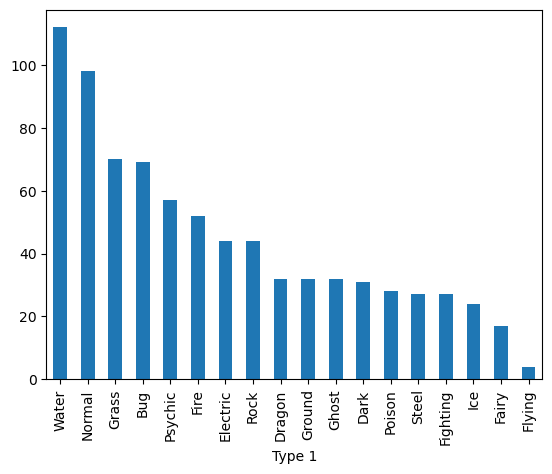

In [2]:
# Charger les données depuis un lien en ligne
lien = "https://raw.githubusercontent.com/leomignot/DataSHS_initiation_python/refs/heads/main/data/pokemon_data.csv"
df = pd.read_csv(lien)

# Afficher la distribution des types de Pokémon avec un graphique (moche)
df["Type 1"].value_counts().plot(kind="bar")

## … ou moins simples …

In [3]:
# Compter uniquement les types principaux (Type 1)
type_counts = df["Type 1"].value_counts().reset_index()

# Graphique en barre
fig = px.bar(
    type_counts,
    x="Type 1",
    y="count",
    color="Type 1",
    title="Distribution des types principaux de Pokémon",
    labels={"count": "Nombre de Pokémon", "Type 1": "Type"},
    # text="Nombre",
)

fig.update_layout(template="plotly_white")
fig.show()

/Users/leo/anaconda3/envs/myenv_clone/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


## Ou pas vraiment simples…

### Graphique en radar (spider chart) pour comparer les statistiques par Pokemon


In [4]:
# Comparer les stats de Carapuce, Bulbasaur et Charmander dans un radar

# Charger et nettoyer les noms de colonnes
lien = "https://raw.githubusercontent.com/leomignot/DataSHS_initiation_python/refs/heads/main/data/pokemon_data.csv"
df = pd.read_csv(lien)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df.rename(columns={"type_1": "type1", "type_2": "type2"}, inplace=True)

# Paramètre optionnel : fixer la borne supérieure de l'axe radial à 150 max si souhaité
fix_axis_max = True  # Passez à False si on veut l'auto-adaptatif
fixed_max = 80

# Liste des Pokémon à comparer (orthographe du jeu de données en anglais)
pokemon_names = ["Bulbasaur", "Charmander", "Squirtle"]
stats_cols = ["hp", "attack", "defense", "sp._atk", "sp._def", "speed"]

# Extraire leurs stats (aucune normalisation)
pokemon_stats = df[df["name"].isin(pokemon_names)][["name"] + stats_cols].reset_index(
    drop=True
)

fig = go.Figure()

# Couleurs personnalisées ou fallback pour chaque Pokémon
color_map = {
    "Bulbasaur": "#78C850",
    "Charmander": "#F08030",
    "Squirtle": "#6890F0",
}

theta = ["HP", "Attaque", "Défense", "Sp. Atk", "Sp. Def", "Vitesse", "HP"]

for idx, row in pokemon_stats.iterrows():
    values = [
        row["hp"],
        row["attack"],
        row["defense"],
        row["sp._atk"],
        row["sp._def"],
        row["speed"],
        row["hp"],
    ]
    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=theta,
            fill="toself",
            name=row["name"],
            line_color=color_map.get(row["name"], "#808080"),
        )
    )

# Définir la plage des axes radiaux selon l'option choisie
min_stat = int(df[stats_cols].min().min())
max_stat = int(df[stats_cols].max().max())
radial_range = [min_stat, fixed_max] if fix_axis_max else [min_stat, max_stat]
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=radial_range)),
    showlegend=True,
    title="Comparaison des stats : Carapuce, Bulbizarre, Salamèche",
    height=600,
    template="plotly_white",
    title_font_size=20,
    font=dict(size=12),
)
fig.show()

## Small multiples : Graphiques radar par type

Grille de graphiques radar individuels pour chaque type, permettant une comparaison visuelle directe.


**Ce graph a largement été généré à l'aide d'un LLM.**

In [5]:
# Mapping de couleurs par type
type_colors = {
    "Normal": "#A8A878",
    "Fire": "#F08030",
    "Water": "#6890F0",
    "Electric": "#F8D030",
    "Grass": "#78C850",
    "Ice": "#98D8D8",
    "Fighting": "#C03028",
    "Poison": "#A040A0",
    "Ground": "#E0C068",
    "Flying": "#A890F0",
    "Psychic": "#F85888",
    "Bug": "#A8B820",
    "Rock": "#B8A038",
    "Ghost": "#705898",
    "Dragon": "#7038F8",
    "Dark": "#705848",
    "Steel": "#B8B8D0",
    "Fairy": "#EE99AC",
}

# Calculer les moyennes par type
stats_cols = ["hp", "attack", "defense", "sp._atk", "sp._def", "speed"]
type_stats = df.groupby("type1")[stats_cols].mean().reset_index()

# Normaliser les stats (0-100)
stats_normalized = type_stats.copy()
for col in stats_cols:
    stats_normalized[col] = (
        (type_stats[col] - type_stats[col].min())
        / (type_stats[col].max() - type_stats[col].min())
        * 100
    )

# Obtenir tous les types uniques
all_types_sorted = sorted(type_stats["type1"].unique())
n_types = len(all_types_sorted)

# Calculer la grille : pour 4 colonnes
n_cols = 4
n_rows = (n_types + n_cols - 1) // n_cols  # Dark magic

# Créer les subplots
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    specs=[[{"type": "polar"}] * n_cols for _ in range(n_rows)],
    subplot_titles=all_types_sorted,
    vertical_spacing=0.1,  # pour ajuster l'intervalle entre lignes
    # horizontal_spacing=0.03,
)

theta = ["HP", "Attaque", "Défense", "Sp. Atk", "Sp. Def", "Vitesse", "HP"]

for idx, poke_type in enumerate(all_types_sorted):
    row = (idx // n_cols) + 1
    col = (idx % n_cols) + 1

    row_data = stats_normalized[stats_normalized["type1"] == poke_type].iloc[0]
    r_values = [
        row_data["hp"],
        row_data["attack"],
        row_data["defense"],
        row_data["sp._atk"],
        row_data["sp._def"],
        row_data["speed"],
        row_data["hp"],
    ]

    fig.add_trace(
        go.Scatterpolar(
            r=r_values,
            theta=theta,
            fill="toself",
            name=poke_type,
            line_color=type_colors.get(poke_type, "#808080"),
            showlegend=False,
        ),
        row=row,
        col=col,
    )

# Configurer tous les axes
polar_config = {}
for idx in range(n_types):
    polar_key = "polar" if idx == 0 else f"polar{idx+1}"
    polar_config[polar_key] = dict(
        radialaxis=dict(visible=True, range=[0, 100], showticklabels=False),
        angularaxis=dict(showticklabels=True, tickfont=dict(size=8)),
    )

fig.update_layout(**polar_config)

fig.update_layout(
    title_text="Profil statistique par type (Small Multiples)",
    title_font_size=20,
    height=280 * n_rows,
    template="plotly_white",
    font=dict(size=10),
)

fig.show()

## Aujourd'hui : on reste simple